In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Lets define a helpful benchmarking function:
import torch.utils.benchmark as benchmark
def benchmark_torch_function_in_microseconds(f, *args, **kwargs):
    t0 = benchmark.Timer(
        stmt="f(*args, **kwargs)", globals={"args": args, "kwargs": kwargs, "f": f}
    )
    return t0.blocked_autorange().mean * 1e6

# Lets define the hyper-parameters of our input
batch_size = 32
max_sequence_len = 128
num_heads = 32
embed_dimension = 32

dtype = torch.float32

# query = torch.rand(batch_size, num_heads, max_sequence_len, embed_dimension, device=device, dtype=dtype)
# key = torch.rand(batch_size, num_heads, max_sequence_len, embed_dimension, device=device, dtype=dtype)
# value = torch.rand(batch_size, num_heads, max_sequence_len, embed_dimension, device=device, dtype=dtype)

# print(f"The default implementation runs in {benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value, None, 0.2):.3f} microseconds")

# # Lets explore the speed of each of the 3 implementations
# from torch.backends.cuda import sdp_kernel, SDPBackend

# # Helpful arguments mapper
# backend_map = {
#     SDPBackend.MATH: {"enable_math": True, "enable_flash": False, "enable_mem_efficient": False},
#     SDPBackend.FLASH_ATTENTION: {"enable_math": False, "enable_flash": True, "enable_mem_efficient": False},
#     SDPBackend.EFFICIENT_ATTENTION: {
#         "enable_math": False, "enable_flash": False, "enable_mem_efficient": True}
# }

# with sdp_kernel(**backend_map[SDPBackend.MATH]):
#     print(f"The math implementation runs in {benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value, None, 0.0):.3f} microseconds")


# with sdp_kernel(**backend_map[SDPBackend.FLASH_ATTENTION]):
#     try:
#         print(f"The flash attention implementation runs in {benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value, None, 0.0):.3f} microseconds")
#     except RuntimeError:
#         print("FlashAttention is not supported. See warnings for reasons.")

# with sdp_kernel(**backend_map[SDPBackend.EFFICIENT_ATTENTION]):
#     try:
#         print(f"The memory efficient implementation runs in {benchmark_torch_function_in_microseconds(F.scaled_dot_product_attention, query, key, value, None, 0.0):.3f} microseconds")
#     except RuntimeError:
#         print("EfficientAttention is not supported. See warnings for reasons.")

In [8]:
query = torch.rand(batch_size, max_sequence_len, num_heads * embed_dimension, device=device, dtype=dtype)
key = torch.rand(batch_size, max_sequence_len, num_heads * embed_dimension, device=device, dtype=dtype)

In [9]:
query.dtype

torch.float32

In [10]:
from modules.attention.roformer_attn import MultiHeadCrossAttention

mhca = MultiHeadCrossAttention(num_heads, embed_dimension * num_heads, 0.0, False).to(device=device, dtype=dtype)

q_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)
kv_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)

# mhca(query, key, q_mask, kv_mask).shape

mhca(query, key, q_mask, kv_mask).shape
# print(f"The stock implementation runs in {benchmark_torch_function_in_microseconds(mhca, query, key, q_mask, kv_mask):.3f} microseconds")

torch.float32 torch.float32 torch.float32
torch.float32 torch.float32


torch.Size([32, 128, 1024])

In [5]:
from modules.attention.xformer import MultiHeadCrossAttention


mhca = MultiHeadCrossAttention(num_heads, embed_dimension * num_heads, 0.0, False).to(device=device, dtype=dtype)

q_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)
kv_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)

# mhca(query, key, q_mask, kv_mask).shape

print(f"The stock implementation runs in {benchmark_torch_function_in_microseconds(mhca, query, key, q_mask, kv_mask):.3f} microseconds")

The stock implementation runs in 319.130 microseconds


In [5]:
from modules.attention.stock import MultiHeadCrossAttention

mhca = MultiHeadCrossAttention(num_heads, embed_dimension * num_heads, 0.0, False).to(device=device, dtype=dtype)

q_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)
kv_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)

# mhca(query, key, q_mask, kv_mask).shape

print(f"The stock implementation runs in {benchmark_torch_function_in_microseconds(mhca, query, key, q_mask, kv_mask):.3f} microseconds")

The stock implementation runs in 470.616 microseconds


In [7]:
from modules.attention.flash import MultiHeadCrossAttention

mhca = MultiHeadCrossAttention(num_heads, embed_dimension * num_heads, 0.0, False).to(device=device, dtype=dtype)

q_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)
kv_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)

print(f"The flash implementation runs in {benchmark_torch_function_in_microseconds(mhca, query, key, q_mask, kv_mask):.3f} microseconds")

The flash implementation runs in 255.802 microseconds


In [8]:
from modules.attention.meme import MultiHeadCrossAttention

mhca = MultiHeadCrossAttention(num_heads, embed_dimension * num_heads, 0.0, False).to(device=device, dtype=dtype)

q_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)
kv_mask = torch.ones(batch_size, max_sequence_len, dtype=torch.bool, device=device)

print(f"The meme implementation runs in {benchmark_torch_function_in_microseconds(mhca, query, key, q_mask, kv_mask):.3f} microseconds")

The meme implementation runs in 264.008 microseconds


In [1]:
import torch

In [5]:
arr = [torch.randn(30, 40, 3) for _ in range(32)]

In [6]:
from einops import rearrange

In [9]:
rearrange(arr, 'b (h1 h) (w1 w) c -> b h1 w1 h w c', h1=2, w1=2).shape

torch.Size([32, 2, 2, 15, 20, 3])

In [13]:
from PIL import Image
from urllib.request import urlopen

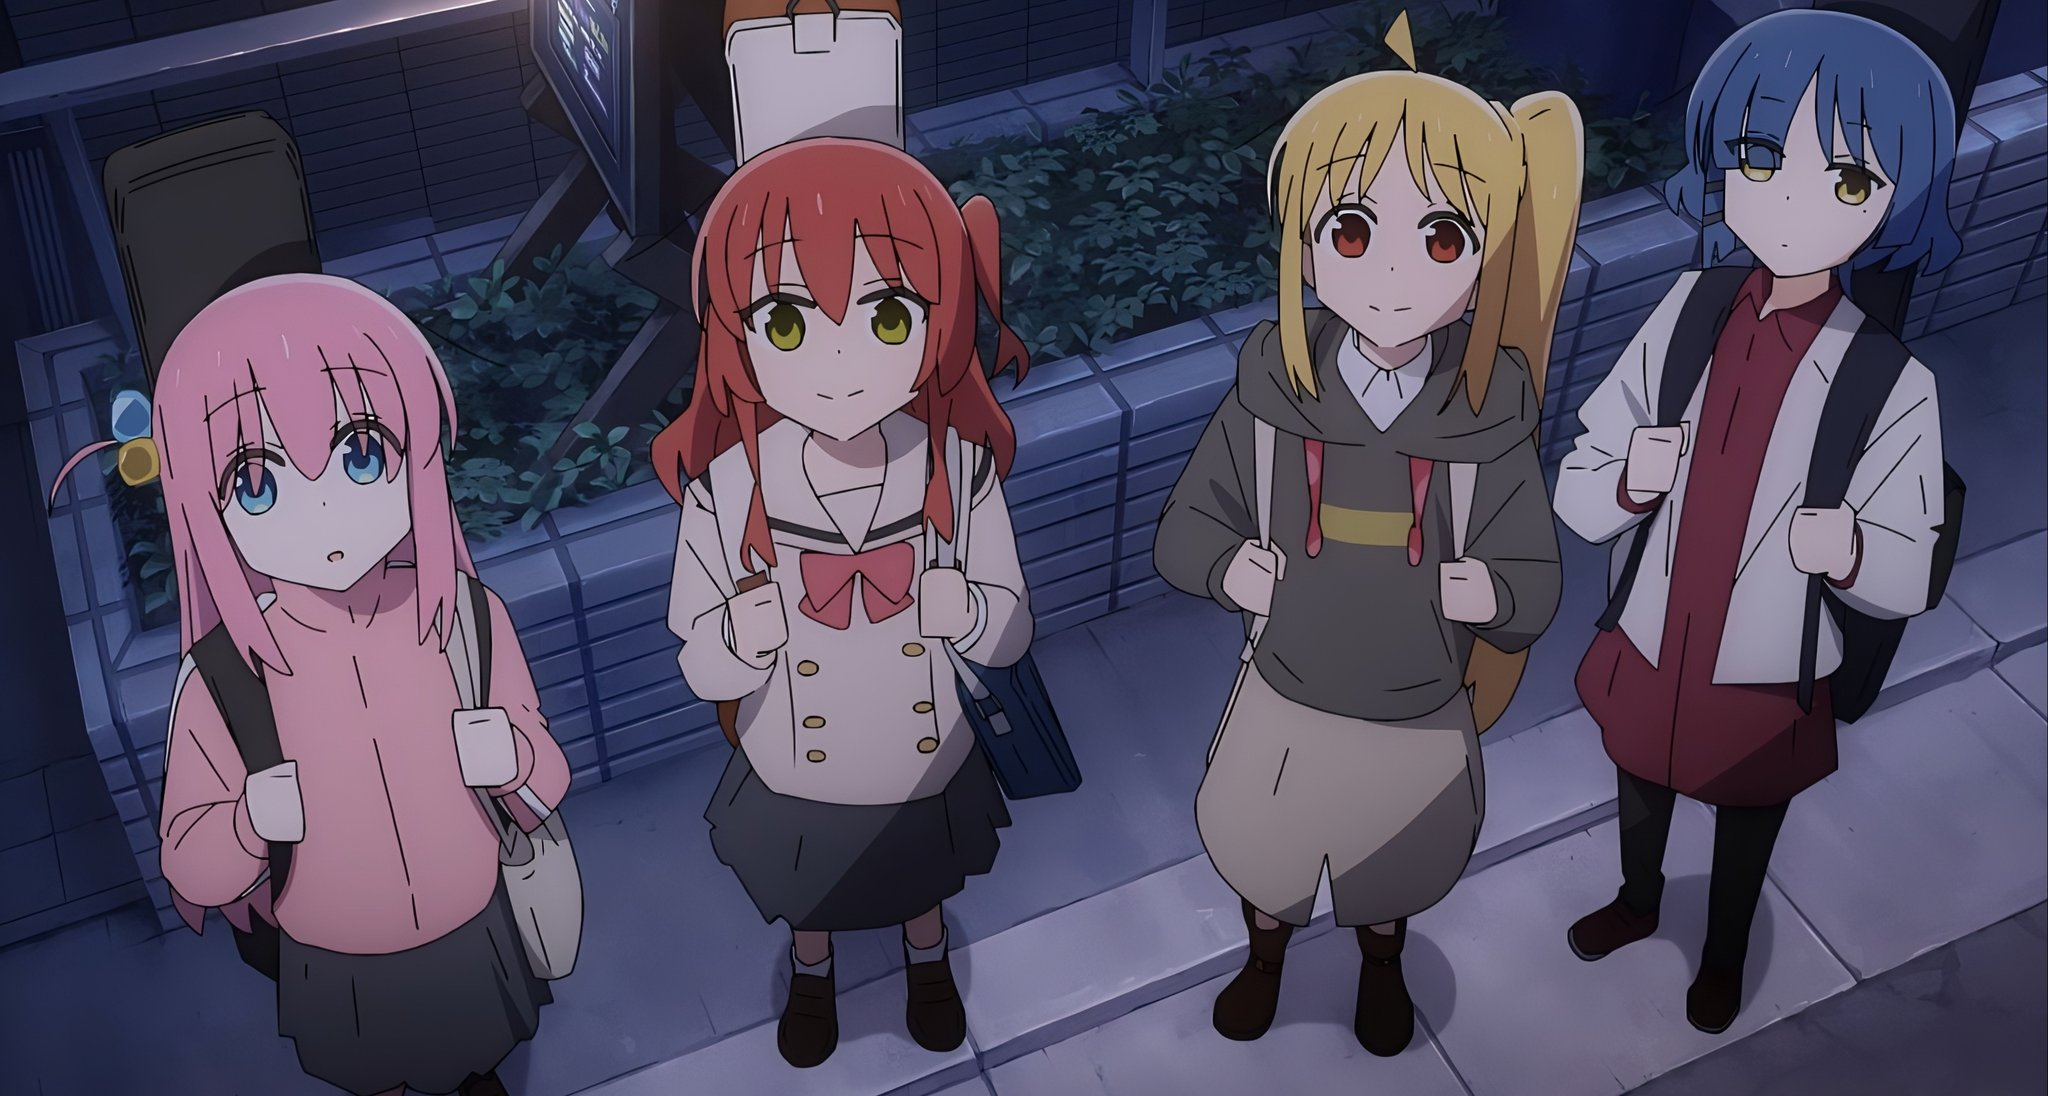

In [14]:
with urlopen('https://i0.wp.com/anitrendz.net/news/wp-content/uploads/2023/01/Bocchi-The-Rock.jpg') as f:
	img = Image.open(f)
img

In [17]:
# convert img to a torch array without using np
import torchvision.transforms.functional as TF

img_tensor = TF.to_tensor(img)
img_tensor.shape

torch.Size([3, 1096, 2048])

In [40]:
splitted = rearrange(img_tensor, 'c h (w w1) -> c h w w1', w1=4)
splitted.shape

torch.Size([3, 1096, 512, 4])

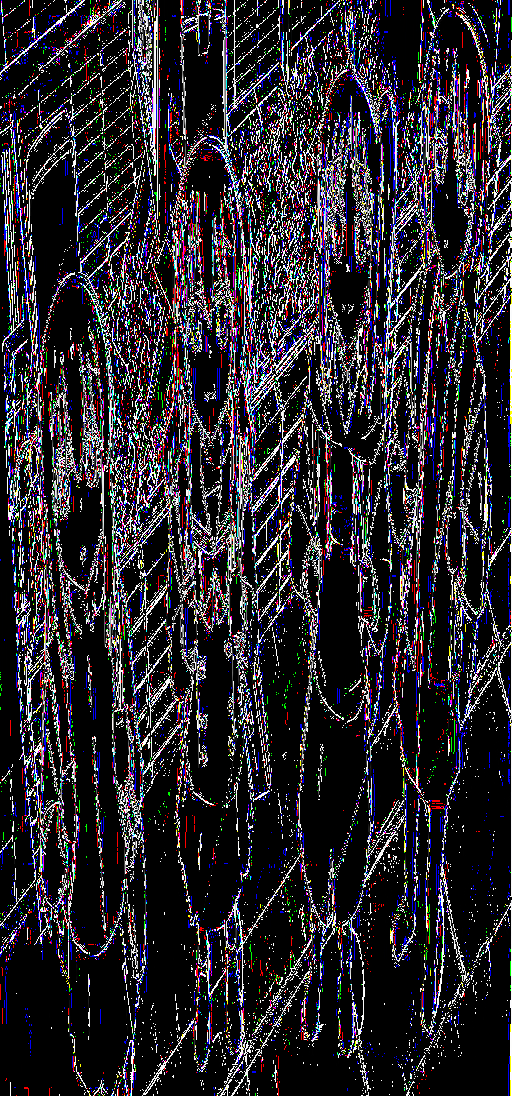

In [51]:
splits = splitted.unbind(dim=-1)
TF.to_pil_image(splits[1] - splits[2], mode='RGB')

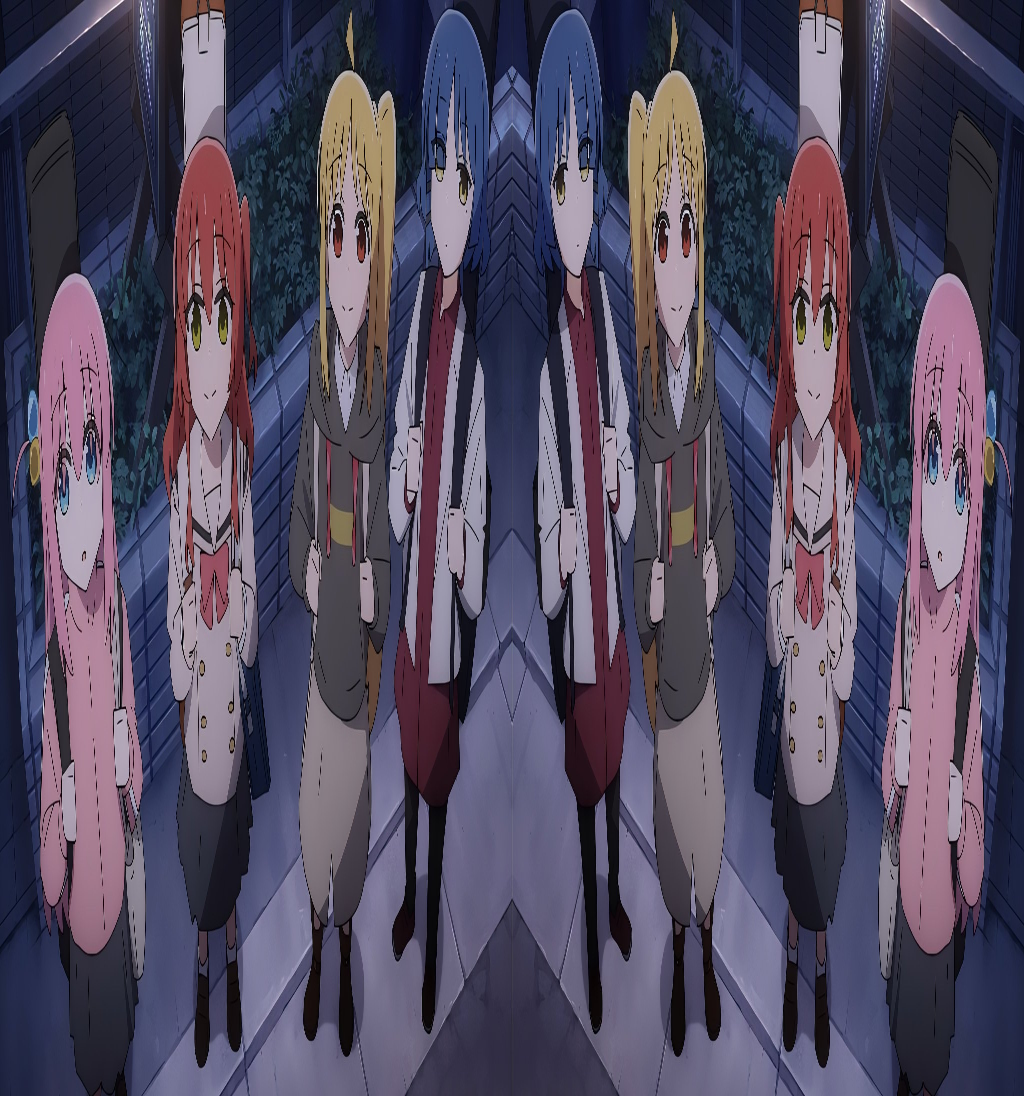

In [66]:
TF.to_pil_image(torch.concat((splits[1], torch.flip(splits[2], dims=(2,))), dim=-1))

In [86]:
theta = 10000
seq_len = 128
hidden_dim = 512

In [108]:
import torch
from torch import nn
from torch import Tensor
import math
import functools

### RotaryEmbedding Helper Functions ###
def get_angles(theta, seq_len, hidden_dim):
	# angular speed
	w = 1. / (theta ** (torch.arange(0, hidden_dim, 2, dtype=torch.float)[:(hidden_dim // 2)] / hidden_dim))
	# time
	t = torch.arange(seq_len, dtype=torch.float)
	angles = torch.einsum('i, j -> i j', t, w)
	return angles

def get_sin_cos(angles):
	return torch.sin(angles), torch.cos(angles)

# Rotate a vector
# x1' = x1 cos - x2 sin
# x2' = x1 sin + x2 cos

def rotate_len2_subvectors(x, sin, cos):
	''' Treat the last dimension as vectors of length 2 and rotate them by the given angles.
	Inputs:
	x: (..., l, d) where d % 2 == 0
	sin: (l, d / 2)
	cos: (l, d / 2)

	Output:
	rotated: (..., l)
	  '''
	assert x.shape[-1] % 2 == 0
	assert sin.shape[-1] == cos.shape[-1] == x.shape[-1] // 2
	x1 = x[..., ::2]
	x2 = x[..., 1::2]
	x1_prime = x1 * cos - x2 * sin
	x2_prime = x1 * sin + x2 * cos
	return torch.stack((x1_prime, x2_prime), dim=-1).flatten(-2)

class RotaryEmbedding(nn.Module):

	@staticmethod
	@functools.cache
	def get_sin_cos(theta, hidden_dim):
		''' Get the sin/cos tables for the given theta and hidden_dim. '''
		if not hasattr(RotaryEmbedding, 'sin') or not hasattr(RotaryEmbedding, 'cos'):
			MAX_SEQ_LEN = 8192 # we hardcode a really big number here to avoid recomputing the sin/cos tables
			angles = get_angles(theta, MAX_SEQ_LEN, hidden_dim)
			RotaryEmbedding.sin, RotaryEmbedding.cos = get_sin_cos(angles)
		return RotaryEmbedding.sin, RotaryEmbedding.cos


	def __init__(self, theta, hidden_dim):
		super().__init__()
		self.theta = theta
		self.hidden_dim = hidden_dim

	def forward(self, x):
		# get sequence length
		T = x.shape[-2]
		# get sin/cos tables
		sin, cos = RotaryEmbedding.get_sin_cos(self.theta, self.hidden_dim)
		# trim to the correct sequence length
		sin = sin[:T, :].to(x.device)
		cos = cos[:T, :].to(x.device)
		# rotate x
		return rotate_len2_subvectors(x, sin, cos)

In [109]:
B = 32
T = 128
H = 8
D = 64

k = torch.ones((B, H, T, D), dtype=torch.float, device='cuda:0')

In [115]:
theta = 10000
rotary_embedding = RotaryEmbedding(theta, D)

out1 = rotary_embedding(k)

In [112]:
from math import pi, log

import torch
from torch import nn, einsum

from einops import rearrange, repeat

# helper functions

def exists(val):
    return val is not None

def broadcat(tensors, dim = -1):
    num_tensors = len(tensors)
    shape_lens = set(list(map(lambda t: len(t.shape), tensors)))
    assert len(shape_lens) == 1, 'tensors must all have the same number of dimensions'
    shape_len = list(shape_lens)[0]

    dim = (dim + shape_len) if dim < 0 else dim
    dims = list(zip(*map(lambda t: list(t.shape), tensors)))

    expandable_dims = [(i, val) for i, val in enumerate(dims) if i != dim]
    assert all([*map(lambda t: len(set(t[1])) <= 2, expandable_dims)]), 'invalid dimensions for broadcastable concatentation'
    max_dims = list(map(lambda t: (t[0], max(t[1])), expandable_dims))
    expanded_dims = list(map(lambda t: (t[0], (t[1],) * num_tensors), max_dims))
    expanded_dims.insert(dim, (dim, dims[dim]))
    expandable_shapes = list(zip(*map(lambda t: t[1], expanded_dims)))
    tensors = list(map(lambda t: t[0].expand(*t[1]), zip(tensors, expandable_shapes)))
    return torch.cat(tensors, dim = dim)

# rotary embedding helper functions

def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

def apply_rotary_emb(freqs, t, start_index = 0, scale = 1.):
    freqs = freqs.to(t)
    rot_dim = freqs.shape[-1]
    end_index = start_index + rot_dim
    assert rot_dim <= t.shape[-1], f'feature dimension {t.shape[-1]} is not of sufficient size to rotate in all the positions {rot_dim}'
    t_left, t, t_right = t[..., :start_index], t[..., start_index:end_index], t[..., end_index:]
    t = (t * freqs.cos() * scale) + (rotate_half(t) * freqs.sin() * scale)
    return torch.cat((t_left, t, t_right), dim = -1)

# learned rotation helpers

def apply_learned_rotations(rotations, t, start_index = 0, freq_ranges = None):
    if exists(freq_ranges):
        rotations = einsum('..., f -> ... f', rotations, freq_ranges)
        rotations = rearrange(rotations, '... r f -> ... (r f)')

    rotations = repeat(rotations, '... n -> ... (n r)', r = 2)
    return apply_rotary_emb(rotations, t, start_index = start_index)

# classes

class RotaryEmbeddingLucid(nn.Module):
    def __init__(
        self,
        dim,
        custom_freqs = None,
        freqs_for = 'lang',
        theta = 10000,
        max_freq = 10,
        num_freqs = 1,
        learned_freq = False,
        use_xpos = False,
        xpos_scale_base = 512,
    ):
        super().__init__()
        if exists(custom_freqs):
            freqs = custom_freqs
        elif freqs_for == 'lang':
            freqs = 1. / (theta ** (torch.arange(0, dim, 2)[:(dim // 2)].float() / dim))
        elif freqs_for == 'pixel':
            freqs = torch.linspace(1., max_freq / 2, dim // 2) * pi
        elif freqs_for == 'constant':
            freqs = torch.ones(num_freqs).float()
        else:
            raise ValueError(f'unknown modality {freqs_for}')

        self.cache = dict()
        self.cache_scale = dict()
        self.freqs = nn.Parameter(freqs, requires_grad = learned_freq)

        self.use_xpos = use_xpos
        if not use_xpos:
            self.register_buffer('scale', None)
            return

        scale = (torch.arange(0, dim, 2) + 0.4 * dim) / (1.4 * dim)
        self.scale_base = xpos_scale_base
        self.register_buffer('scale', scale)

    def rotate_queries_or_keys(self, t, seq_dim = -2):
        assert not self.use_xpos, 'you must use `.rotate_queries_and_keys` method instead and pass in both queries and keys, for length extrapolatable rotary embeddings'
        device, seq_len = t.device, t.shape[seq_dim]
        freqs = self.forward(lambda: torch.arange(seq_len, device = device), cache_key = seq_len)
        return apply_rotary_emb(freqs, t)

    def rotate_queries_and_keys(self, q, k, seq_dim = -2):
        assert self.use_xpos
        device, seq_len = q.device, q.shape[seq_dim]
        seq = torch.arange(seq_len, device = device)
        freqs = self.forward(lambda: seq, cache_key = f'freqs:{seq_len}')
        scale = self.get_scale(lambda: seq, cache_key = f'scale:{seq_len}')
        rotated_q = apply_rotary_emb(freqs, q, scale = scale)
        rotated_k = apply_rotary_emb(freqs, k, scale = scale ** -1)
        return rotated_q, rotated_k

    def get_scale(self, t, cache_key = None):
        assert self.use_xpos

        if exists(cache_key) and cache_key in self.cache:
            return self.cache[cache_key]

        if callable(t):
            t = t()

        scale = 1.
        if self.use_xpos:
            power = (t - len(t) // 2) / self.scale_base
            scale = self.scale ** rearrange(power, 'n -> n 1')
            scale = torch.cat((scale, scale), dim = -1)

        if exists(cache_key):
            self.cache[cache_key] = scale

        return scale

    def forward(self, t, cache_key = None):
        if exists(cache_key) and cache_key in self.cache:
            return self.cache[cache_key]

        if callable(t):
            t = t()

        freqs = self.freqs

        freqs = torch.einsum('..., f -> ... f', t.type(freqs.dtype), freqs)
        freqs = repeat(freqs, '... n -> ... (n r)', r = 2)

        if exists(cache_key):
            self.cache[cache_key] = freqs

        return freqs


In [116]:
rotary_embedding_lucid = RotaryEmbeddingLucid(D).to('cuda:0')
out2 = rotary_embedding_lucid.rotate_queries_or_keys(k)

In [138]:
k = torch.randn((1024, H, T, D), dtype=torch.float, device='cuda:0')
out1 = rotary_embedding(k)
out2 = rotary_embedding_lucid.rotate_queries_or_keys(k)

# print max diff
print('Max Diff:', (out1 - out2).abs().max().item())
# print mean diff
print('Mean Diff:', (out1 - out2).abs().mean().item())
# print std diff
print('Std Diff:', (out1 - out2).abs().std().item())

Max Diff: 9.5367431640625e-07
Mean Diff: 9.750485752135774e-09
Std Diff: 3.2006010286522724e-08


In [107]:
import torch

# Example input arrays
array1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
array2 = torch.tensor([[7, 8, 9], [10, 11, 12]])

# Interleave on the last dimension
interleaved = torch.stack((array1, array2), dim=-1)
interleaved = interleaved

print(interleaved.flatten(-2))


tensor([[ 1,  7,  2,  8,  3,  9],
        [ 4, 10,  5, 11,  6, 12]])


In [80]:
import numpy as np

A = np.array([[[1, 2, 3, 4],
               [5, 6, 7, 8],
               [9, 10, 11, 12]],
              
              [[13, 14, 15, 16],
               [17, 18, 19, 20],
               [21, 22, 23, 24]]])

output = np.einsum('...f -> ...', A)

print(output)


[[10 26 42]
 [58 74 90]]


In [81]:
A.shape

(2, 3, 4)